<a href="https://colab.research.google.com/github/hinakawasan/bruno/blob/master/20221207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インポート

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.3.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 14.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl size=44634 sha256=f9312a69f98ec317f9315b9bb8bf3a6305339ffa3634b1574491876517a39387
  Stored in directory: /root/.cache/pip/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 14634 (delta 16), reused 33 (delta 7), pack-reused 14584
Receiving objects: 100% (14634/14634), 5.99 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (10574/10574), done.
Looking in indexes: https://pypi.org/simple, https://u

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2,random
from google.colab.patches import cv2_imshow

#import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# COCOの登録

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances('check',{},'/content/drive/MyDrive/20221206_data/labelme2coco/dataset.json','/content/drive/MyDrive/20221206_data/train')

In [ ]:
check_metadata = MetadataCatalog.get('check')

# アノテーションの確認をする

WARNING [12/07 09:00:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/07 09:00:26 d2.data.datasets.coco]: Loaded 1212 images in COCO format from /content/drive/MyDrive/20221206_data/labelme2coco/dataset.json


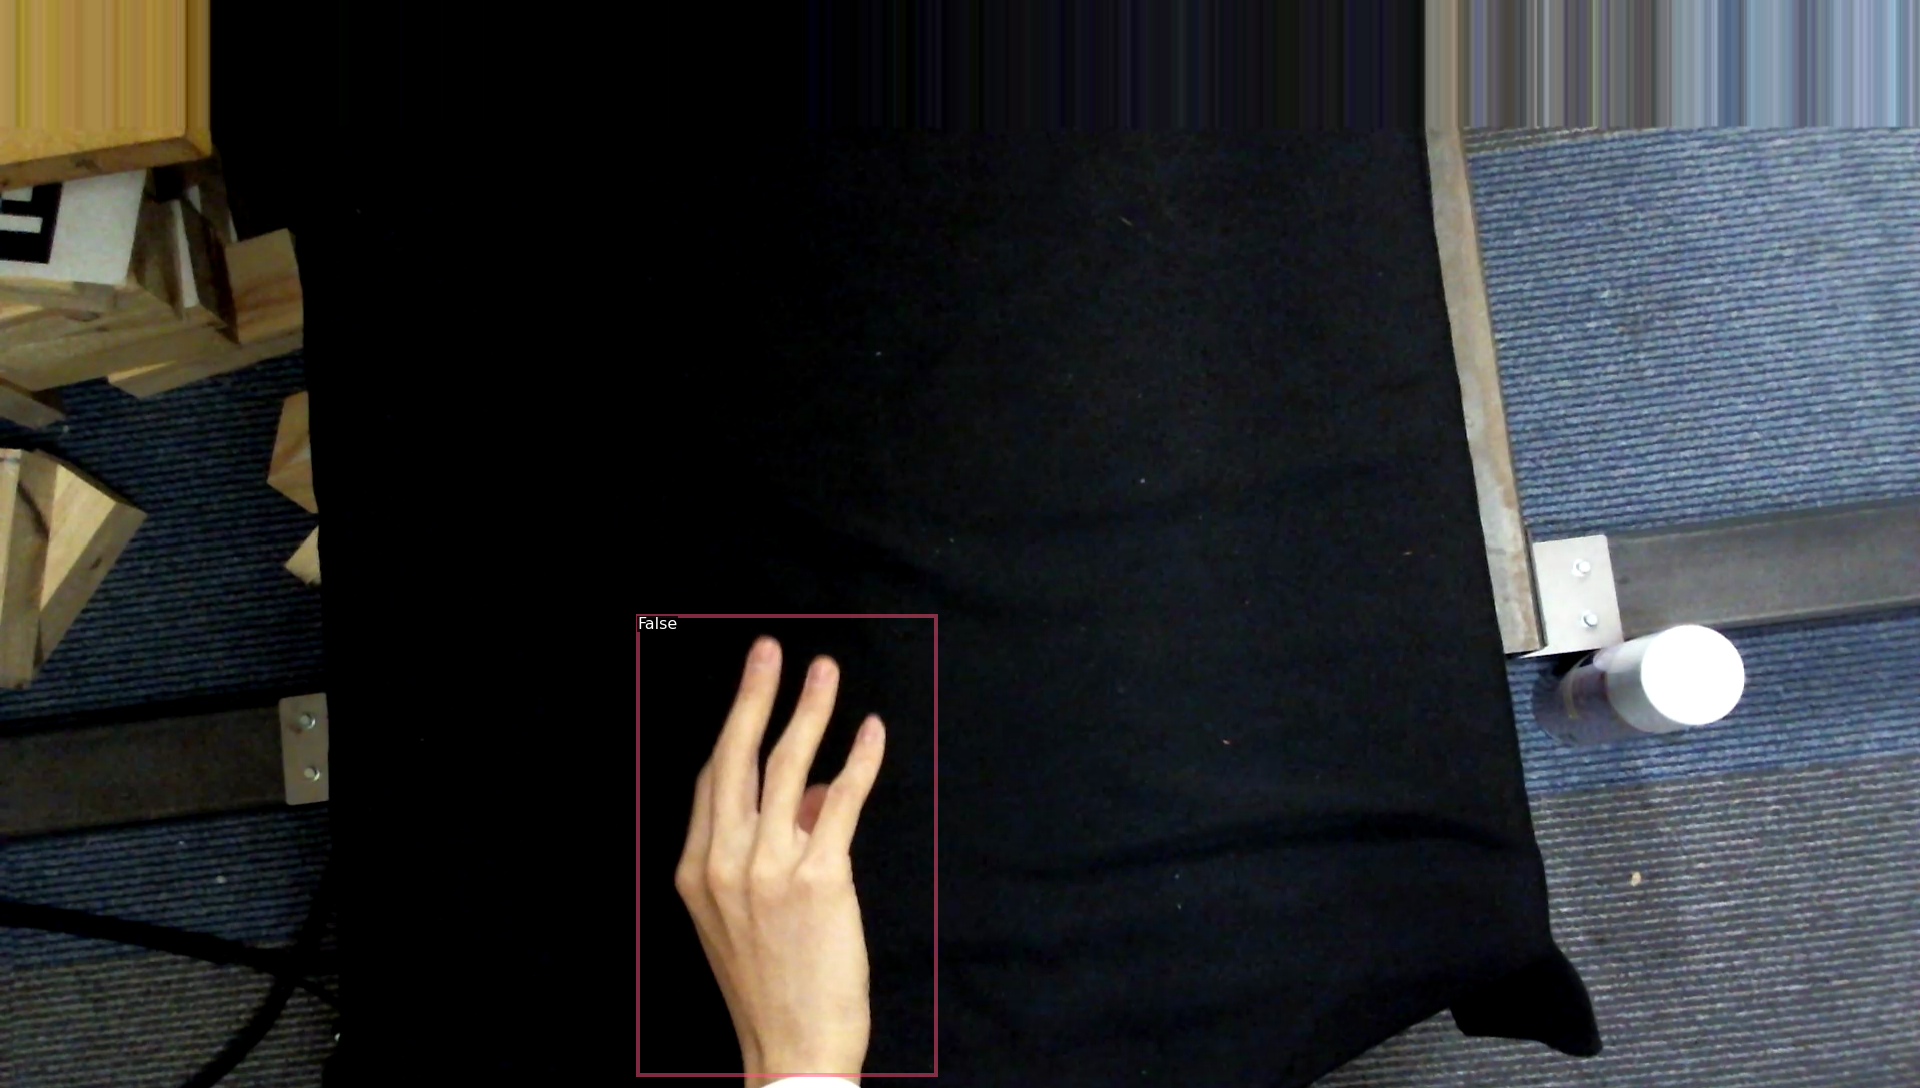

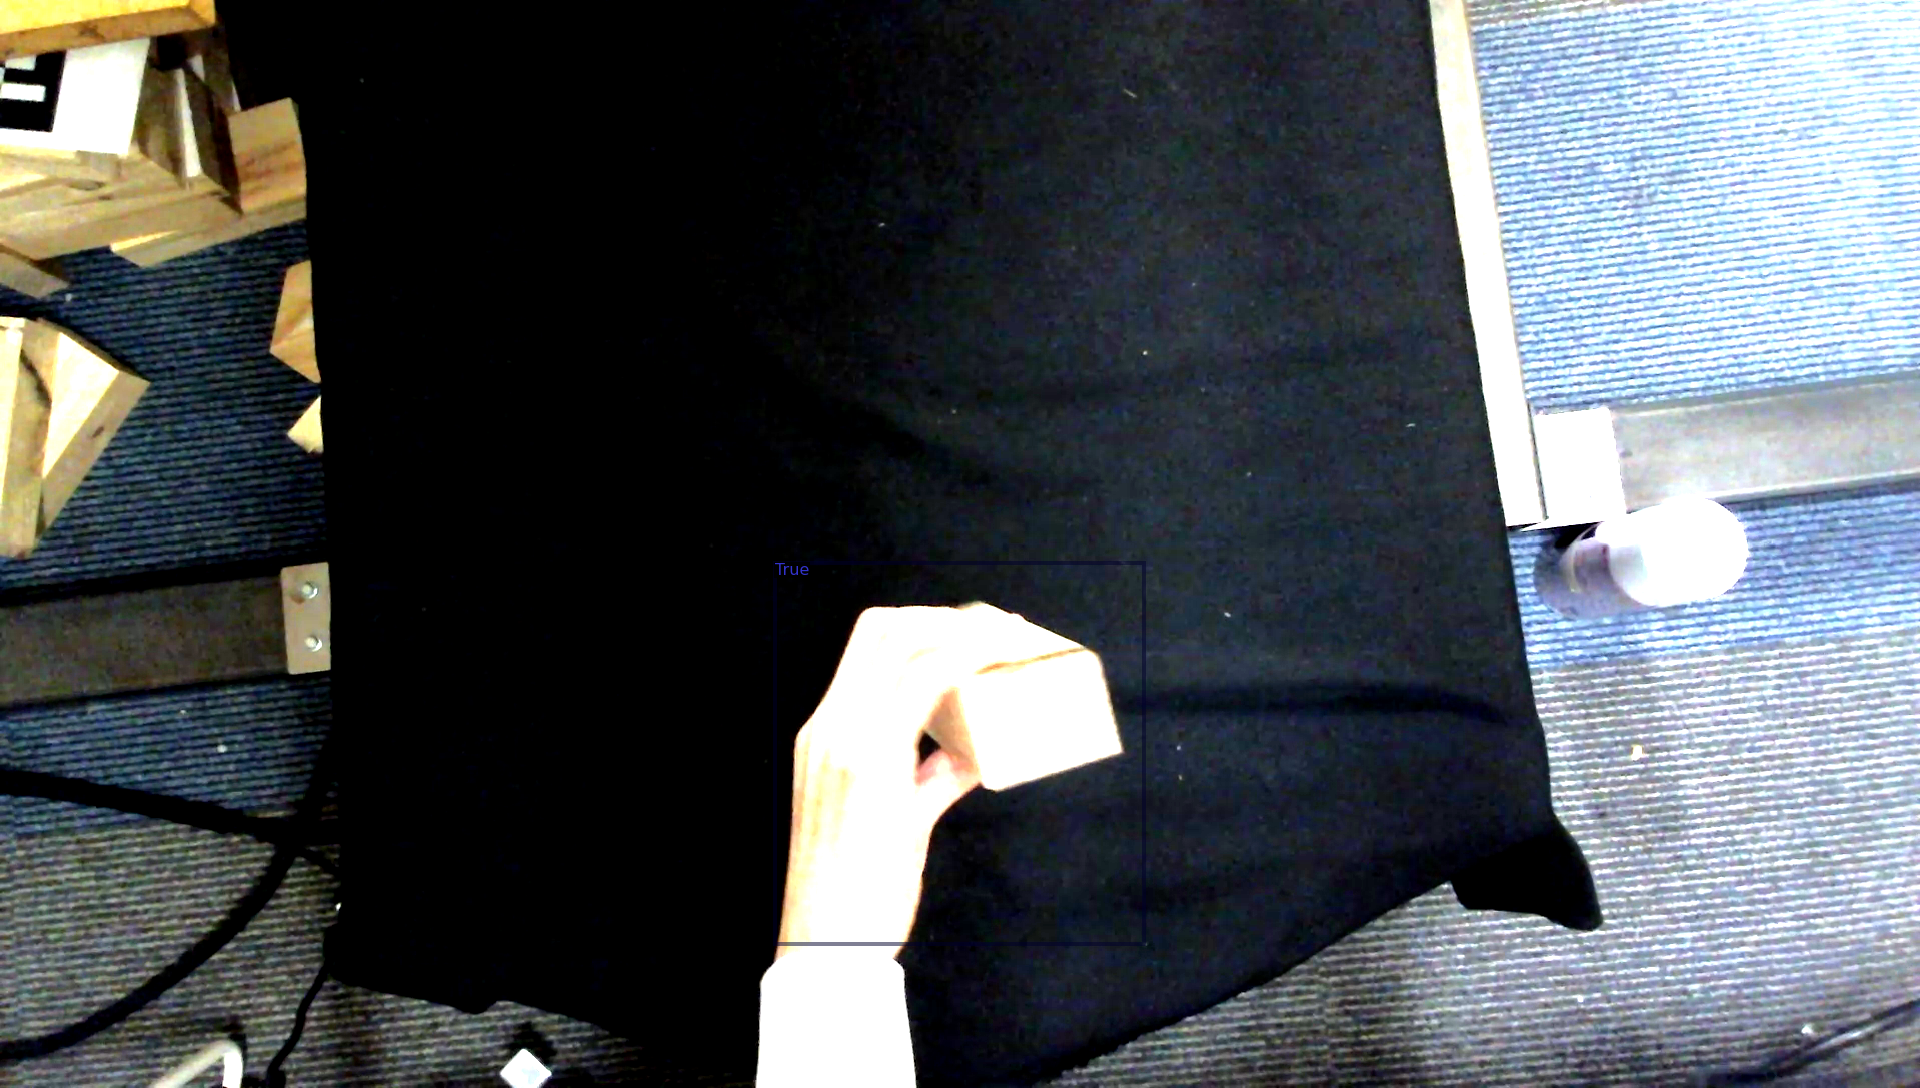

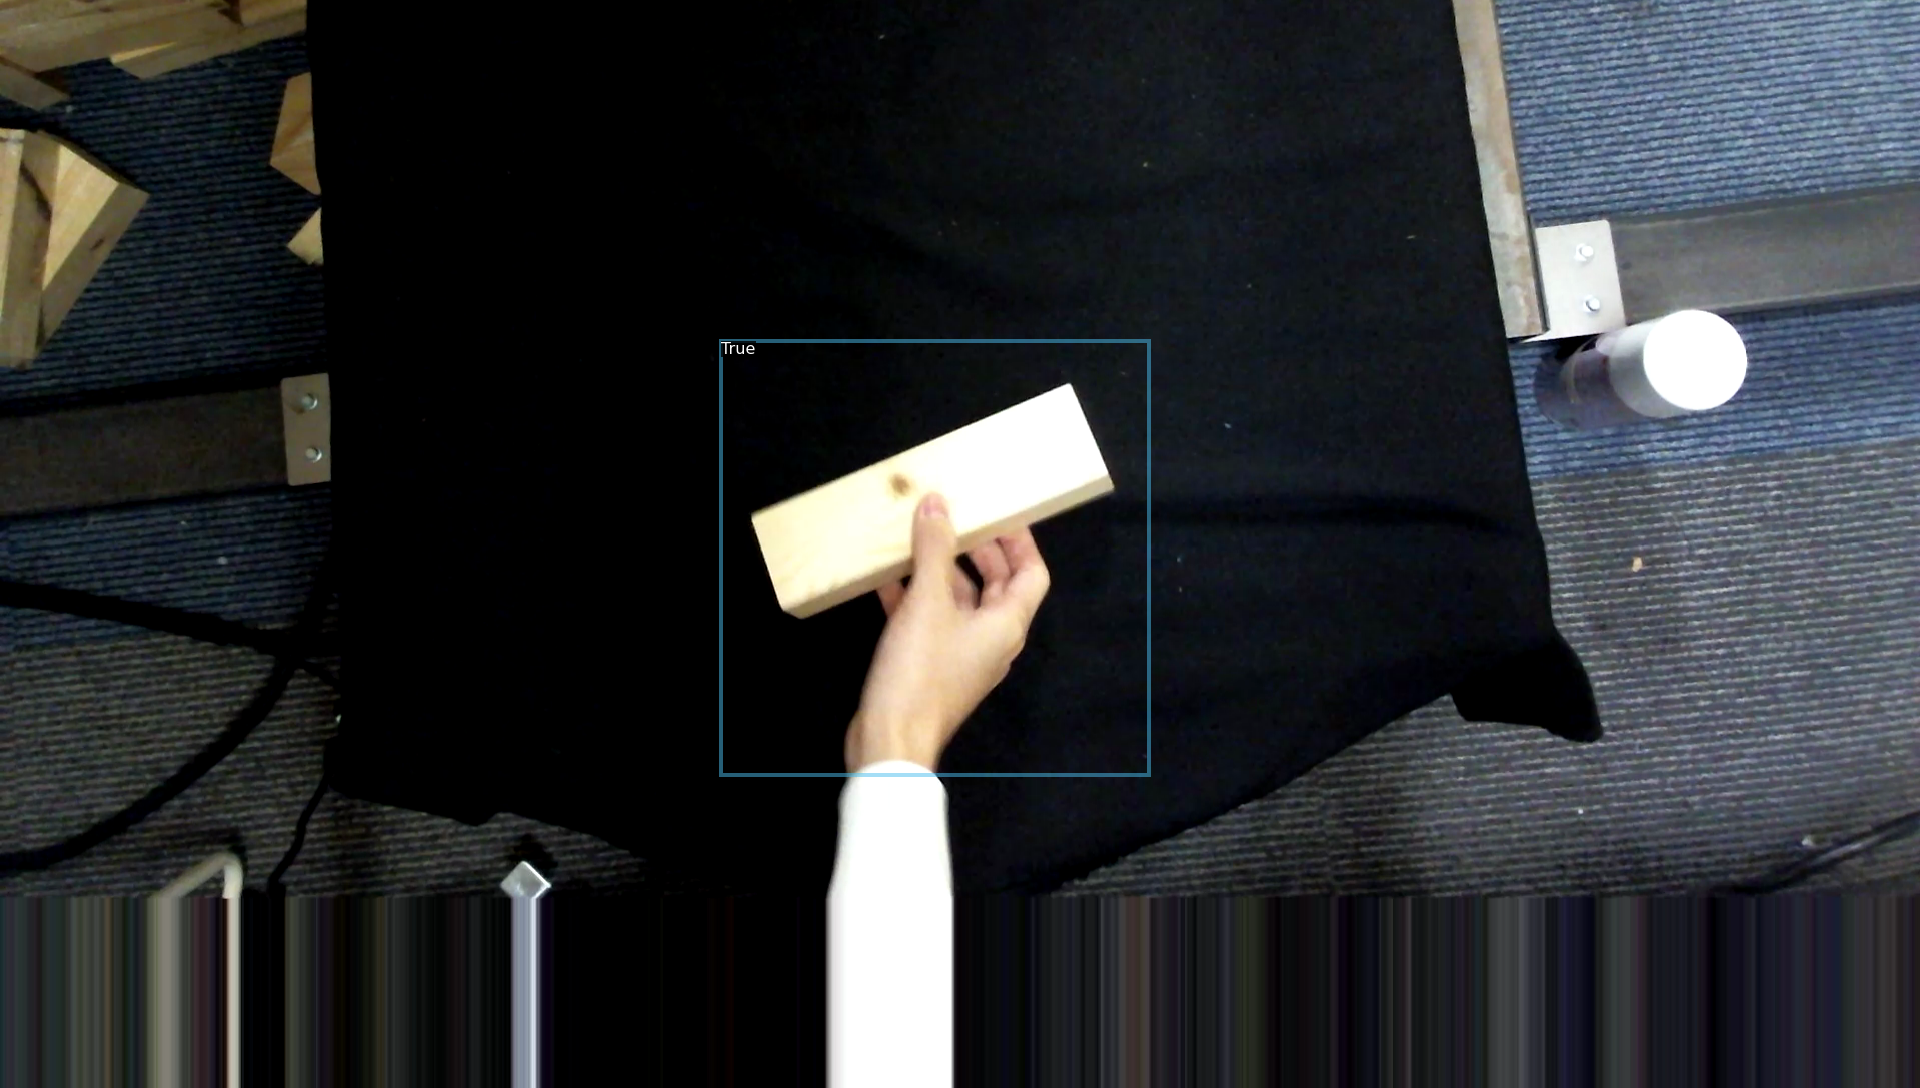

In [ ]:
dataset_dicts = DatasetCatalog.get("check")

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=check_metadata, scale=1.0)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

# モデルの学習

In [ ]:
from detectron2.engine import DefaultTrainer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("check",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.0007  # pick a good LR
cfg.SOLVER.MAX_ITER = 700    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 2クラスのみ
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/08 09:00:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/08 09:00:25 d2.engine.train_loop]: Starting training from iteration 0
[12/08 09:00:58 d2.utils.events]:  eta: 0:18:00  iter: 19  total_loss: 1.35  loss_cls: 1.087  loss_box_reg: 0.2739  loss_rpn_cls: 0.01392  loss_rpn_loc: 0.00869  time: 1.6378  data_time: 0.3077  lr: 1.9681e-05  max_mem: 6170M
[12/08 09:01:28 d2.utils.events]:  eta: 0:16:40  iter: 39  total_loss: 1.011  loss_cls: 0.7017  loss_box_reg: 0.278  loss_rpn_cls: 0.01037  loss_rpn_loc: 0.007035  time: 1.5574  data_time: 0.2245  lr: 3.9661e-05  max_mem: 6170M
[12/08 09:01:58 d2.utils.events]:  eta: 0:16:05  iter: 59  total_loss: 0.6628  loss_cls: 0.3624  loss_box_reg: 0.2913  loss_rpn_cls: 0.01157  loss_rpn_loc: 0.007648  time: 1.5441  data_time: 0.2474  lr: 5.9641e-05  max_mem: 6170M
[12/08 09:02:29 d2.utils.events]:  eta: 0:15:35  iter: 79  total_loss: 0.5869  loss_cls: 0.2654  loss_box_reg: 0.2859  loss_rpn_cls: 0.01038  loss_rpn_loc: 0.008558  time: 1.5432  data_time: 0.2459  lr: 7.9621e-05  max_mem: 6170M
[12/08 09:03

# jsonファイル読み込み

In [ ]:
import json
json_open = open('/content/output/metrics.json', 'r')

json_load = json.load(json_open)
print(json_load)

[{'data_time': 0.23290901600012148, 'eta_seconds': 1080.9280214204045, 'fast_rcnn/cls_accuracy': 0.394140625, 'fast_rcnn/false_negative': 0.6597413318657127, 'fast_rcnn/fg_cls_accuracy': 0.13772534464475078, 'iteration': 19, 'loss_box_reg': 0.27386489510536194, 'loss_cls': 1.0867211818695068, 'loss_rpn_cls': 0.013917475007474422, 'loss_rpn_loc': 0.008690338116139174, 'lr': 1.9681e-05, 'roi_head/num_bg_samples': 238.9, 'roi_head/num_fg_samples': 17.1, 'rpn/num_neg_anchors': 252.3, 'rpn/num_pos_anchors': 3.7, 'time': 1.589600031500595, 'total_loss': 1.349753113463521}, {'data_time': 0.22334246249920398, 'eta_seconds': 1000.0400394604003, 'fast_rcnn/cls_accuracy': 0.91875, 'fast_rcnn/false_negative': 1.0, 'fast_rcnn/fg_cls_accuracy': 0.0, 'iteration': 39, 'loss_box_reg': 0.27802594006061554, 'loss_cls': 0.7016588151454926, 'loss_rpn_cls': 0.010365025140345097, 'loss_rpn_loc': 0.007034841226413846, 'lr': 3.9661000000000005e-05, 'roi_head/num_bg_samples': 238.5, 'roi_head/num_fg_samples': 1

In [ ]:
l_loss = [d.get('total_loss') for d in json_load]
print(l_loss)

[1.349753113463521, 1.0108449652325362, 0.6627608058042824, 0.5869003003463149, 0.5243012236896902, 0.5130499250954017, 0.5113811516202986, 0.47827668441459537, 0.48103372007608414, 0.463383127033012, 0.45058986416552216, 0.44669979193713516, 0.4200247703702189, 0.40996375458780676, 0.4067065150884446, 0.3757946904916025, 0.358588307755781, 0.3343870973385492, 0.26041031741124243, 0.23615730431447446, 0.24602637785937986, 0.20821305620484054, 0.2046045709473674, 0.1829191402770931, 0.18090425735567806, 0.1822087608861409, 0.18744014355706895, 0.1792667228900484, 0.1709084800677374, 0.17681694628220157, 0.16924851904573757, 0.18306409144997815, 0.16605646884772796, 0.17295733811897662]


In [ ]:
l_loss_class = [d.get('loss_cls') for d in json_load]
print(l_loss_class)

[1.0867211818695068, 0.7016588151454926, 0.3623875081539154, 0.2653515040874481, 0.22954841703176498, 0.20534531772136688, 0.18978549540042877, 0.1629159301519394, 0.1527465581893921, 0.1398647502064705, 0.12986305356025696, 0.12055370956659317, 0.10832791030406952, 0.09724190086126328, 0.08969979733228683, 0.08344128355383873, 0.07683999463915825, 0.06746586039662361, 0.05630023218691349, 0.05306507647037506, 0.05572119913995266, 0.04524305276572704, 0.045571545138955116, 0.03747992217540741, 0.03629959002137184, 0.037692198529839516, 0.04284691624343395, 0.03438301011919975, 0.03582894802093506, 0.03772176057100296, 0.0389770083129406, 0.037063686177134514, 0.03185843303799629, 0.03843959607183933]


# グラフを表示

<function matplotlib.pyplot.show(*args, **kw)>

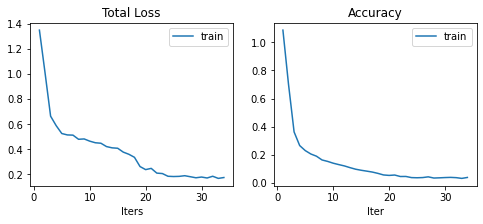

In [ ]:
n_iters = 34
iters = np.arange(1, n_iters + 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

# 損失の推移
ax1.set_title("Total Loss")
ax1.plot(iters, [ d['total_loss'] for d in json_load], label="train")
ax1.set_xlabel("Iters")
ax1.legend()

# 精度の推移
ax2.set_title("Accuracy")
ax2.plot(iters, [ d['loss_cls'] for d in json_load], label="train")
ax2.set_xlabel("Iter")
ax2.legend()

plt.show


# テストデータの推論

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, '/content/output/model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)

[12/08 09:22:34 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

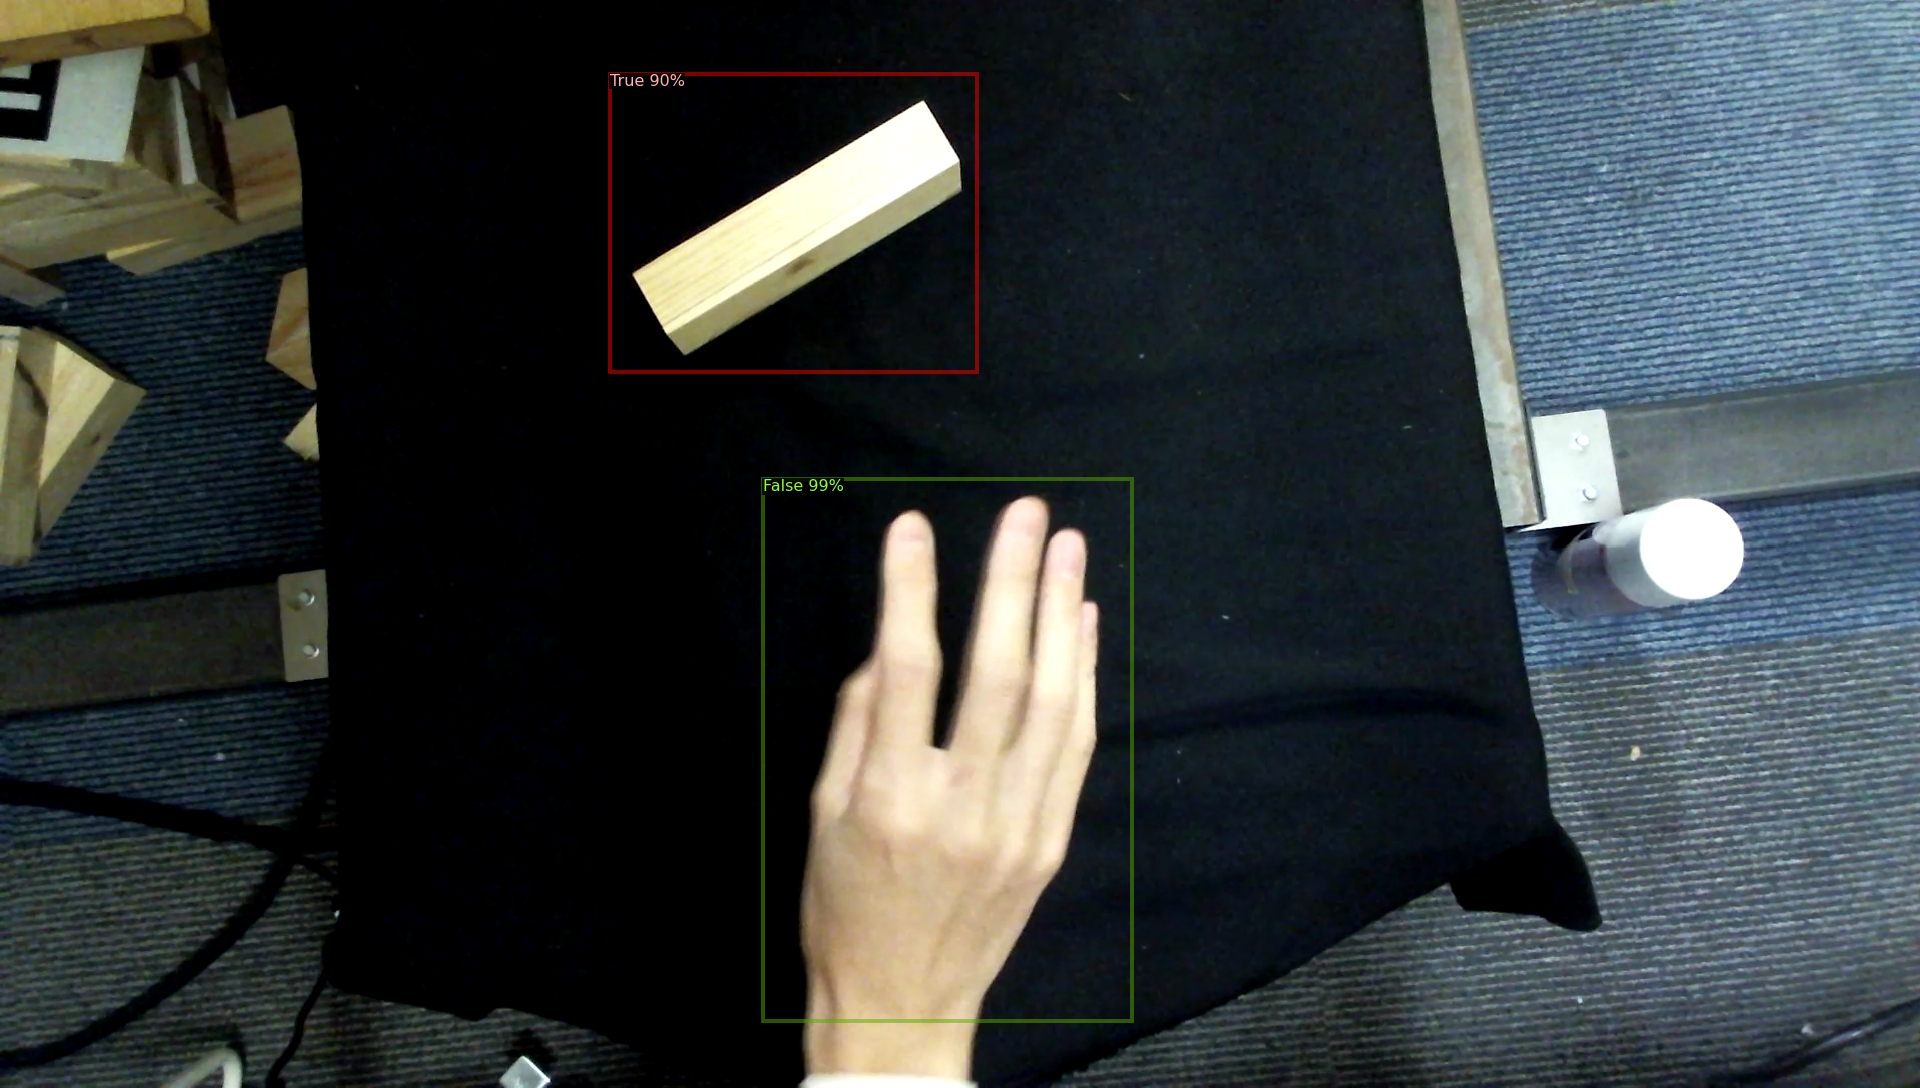

{'instances': Instances(num_instances=2, image_height=1088, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 762.7605,  479.0784, 1131.7402, 1021.3302],
         [ 609.7858,   73.7565,  976.6424,  371.8111]])), scores: tensor([0.9881, 0.8977]), pred_classes: tensor([0, 1])])}

In [ ]:
from detectron2.utils.visualizer import Visualizer
import cv2

imgPath = "/content/drive/MyDrive/20221206_data/test/test_7.png"
im = cv2.imread(imgPath)
    
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=check_metadata, 
               scale=1.0
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

outputs

In [ ]:
from detectron2.utils.visualizer import Visualizer
import cv2
num = 1
while num<13:
  im = cv2.imread(f'/content/drive/MyDrive/20221206_data/test/test_{num}.png')

  outputs = predictor(im)
  v = Visualizer(im[:,:,::-1],
                metadata=check_metadata,
                scale=1.0)
  v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
  img_array = v.get_image()
  img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
  # [:, :, ::-1]：色を BGR から RGB に反転
  # cv2_imshow(img_rgb)
  cv2.imwrite(f'/content/drive/MyDrive/20221206_data/results_1208/result_{num}.png', img_rgb)
  num += 1